# load packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.WARNING)
import os
import random
import importlib
importlib.invalidate_caches()
import tensorflow as tf
tf.compat.v1.reset_default_graph()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from AddaGCN import AddaGCN_API

def visualize_pie(proportion, spatial_location, colors=None, radius=None, seed=None):
    # Convert inputs to DataFrames
    res_results = pd.DataFrame(proportion)
    res_results = res_results.reindex(sorted(res_results.columns), axis=1)  # Equivalent to mixedsort
    
    location = pd.DataFrame(spatial_location)
    
    # Check if row names match
    if not res_results.index.equals(location.index):
        raise ValueError("The rownames of proportion data does not match with the rownames of spatial location data")
    
    # Define color candidates (same as in R code)
    colorCandidate = [
        "#1e77b4", "#ff7d0b", "#ceaaa3", "#2c9f2c", "#babc22", "#d52828", "#9267bc",
        "#8b544c", "#e277c1", "#d42728", "#adc6e8", "#97df89", "#fe9795", "#4381bd",
        "#f2941f", "#5aa43a", "#cc4d2e", "#9f83c8", "#91675a", "#da8ec8", "#929292",
        "#c3c237", "#b4e0ea", "#bacceb", "#f7c685", "#dcf0d0", "#f4a99f", "#c8bad8",
        "#F56867", "#FEB915", "#C798EE", "#59BE86", "#7495D3", "#D1D1D1", "#6D1A9C",
        "#15821E", "#3A84E6", "#997273", "#787878", "#DB4C6C", "#9E7A7A", "#554236",
        "#AF5F3C", "#93796C", "#F9BD3F", "#DAB370", "#877F6C", "#268785", "#f4f1de",
        "#e07a5f", "#3d405b", "#81b29a", "#f2cc8f", "#a8dadc", "#f1faee", "#f08080"
    ]
    
    # Handle colors
    if colors is None:
        if len(res_results.columns) > len(colorCandidate):
            # Create a color palette if needed
            cmap = plt.cm.get_cmap('Spectral')
            colors = [mcolors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(res_results.columns))]
        else:
            if seed is not None:
                random.seed(seed)
            colors = random.sample(colorCandidate, len(res_results.columns))
    else:
        colors = colors
    
    # Combine data
    data = pd.concat([res_results, location], axis=1)
    ct_select = res_results.columns.tolist()
    
    # Calculate radius if not provided
    if radius is None:
        x_range = data['x'].max() - data['x'].min()
        y_range = data['y'].max() - data['y'].min()
        area = x_range * y_range
        radius = np.sqrt((area / len(data)) / np.pi) * 0.7
    else:
        radius = radius
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create pie charts for each point
    for idx, row in data.iterrows():
        x, y = row['x'], row['y']
        proportions = row[ct_select].values
        proportions = proportions / proportions.sum()  # Normalize
        
        # Calculate cumulative sums for wedge angles
        cumsum = np.cumsum(proportions)
        cumsum = np.insert(cumsum, 0, 0)
        
        # Create wedges
        wedges = []
        for i in range(len(proportions)):
            theta1 = cumsum[i] * 360
            theta2 = cumsum[i+1] * 360
            wedge = Wedge((x, y), radius, theta1, theta2, facecolor=colors[i])
            wedges.append(wedge)
        
        # Add wedges to plot
        pc = PatchCollection(wedges, match_original=True, edgecolor='none')
        ax.add_collection(pc)
    
    # Set aspect ratio
    ax.set_aspect('equal')
    
    # Set plot limits
    x_margin = (data['x'].max() - data['x'].min()) * 0.1
    y_margin = (data['y'].max() - data['y'].min()) * 0.1
    ax.set_xlim(data['x'].min() - x_margin, data['x'].max() + x_margin)
    ax.set_ylim(data['y'].min() - y_margin, data['y'].max() + y_margin)
    
    # Customize plot appearance
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Create legend
    legend_patches = [plt.Rectangle((0,0), 1, 1, fc=color) for color in colors]
    ax.legend(legend_patches, ct_select, title='Cell Type', 
              bbox_to_anchor=(1.05, 1), loc='upper left', 
              borderaxespad=0., frameon=False)
    
    plt.tight_layout()
    return fig, ax

2025-04-14 21:43:14.376757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-04-14 21:43:14.385889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:16:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2025-04-14 21:43:14.386145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:34:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2025-04-14 21:43:14.386370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:ac:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 9

# load Data
This tutorial demonstrates AddaGCN's ablility to accurate and robust decomposition of cell-type compositions in the mouse brain dataset.

In this tutorial, the mouse brain spatial data was acquired from https://www.10xgenomics.com/ and single-cell data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115746.

In [2]:
input_dir = os.path.join('../AddaGCN')
os.chdir(input_dir)

adata_sp = sc.read_visium('Data/MB/spatial/V1_Mouse_Brain_Sagittal_Anterior', 
                          count_file="filtered_feature_bc_matrix.h5")
adata_sp.var_names_make_unique()

#Sc data GSE115746
adata_sc = sc.read_csv('Data/MB/reference/GSE115746_cells_exon_counts.csv').T
adata_sc_meta = pd.read_csv('Data/MB/reference/GSE115746_complete_metadata_28706-cells.csv', index_col=0)
adata_sc_meta_ = adata_sc_meta.loc[adata_sc.obs.index,]
adata_sc.obs = adata_sc_meta_
adata_sc.var_names_make_unique()
adata_sc.obs['cellType'] = adata_sc.obs['cell_subclass']

to_remove = ['Pvalb', 'L4', 'Vip', 'L2/3 IT', 'Lamp5', 'NP', 'Sst', 'L5 IT', 'Oligo', 'L6 CT', 'L6 IT','Sncg', 'Serpinf1', 'L5 PT',
             'Astro', 'L6b', 'Endo', 'Peri', 'Meis2', 'Macrophage',  'CR', 'VLMC', 'SMC'] 
mask = adata_sc.obs['cellType'].isin(to_remove)  
adata_sc = adata_sc[mask].copy() 

# train model

In [3]:
AddaGCN = AddaGCN_API(adata_sp, adata_sc, num_markers=20, 
                      n_samples=6000,  nmix=8, 
                      sample_iter = 2,  ct_unm_fix = 2,
                      celltype = 'cellType', sp= 'spatial')
AddaGCN.Train_(loss_weight = [0.1, 1], epochs=1000, lr=[0.001,0.001], 
               initial_train_epochs=10, emb_dim=64,
               initial_train = True,enable_dann = True)

... marker gene ...
36672344000.0 (21874, 45768)
37843940000.0 (21874, 45768)
793858700.0 (21874, 45768)
-6543871.0 (21874, 45768)
... pseudo ...
... Pseudo number ...
Fixed number : 3588
Unfixed number : 2412
4986119.0 (2695, 382)
5026175.0 (2695, 382)
1013914.94 (2695, 382)
-286.93353 (2695, 382)
1171578847.7046537 (6000, 382)
1117697249.9999995 (6000, 382)
8274641.700434057 (6000, 382)
-1.420630724169314e-09 (6000, 382)
... Graph ...
------Calculating spatial graph...
... Calculating A matrix ...
<class 'numpy.matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'numpy.ndarray'>


2025-04-14 21:48:28.946333: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-04-14 21:48:28.968783: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1896000000 Hz
2025-04-14 21:48:28.978200: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe408000b70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-14 21:48:28.978241: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-14 21:48:29.063468: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5e6aa00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-14 21:48:29.063526: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-14 21:48:29.064431: I tensorf

initial_train_done
Epoch: 0000 train_loss= 3.1217 train_acc= 0.2432 val_loss= 3.1219 val_acc= 0.2537 test_loss= 3.1215 test_acc= 0.2700 time= 0.7665
Epoch: 0200 train_loss= 2.6926 train_acc= 0.6243 val_loss= 2.6928 val_acc= 0.6463 test_loss= 2.6919 test_acc= 0.6150 time= 0.4510
Epoch: 0400 train_loss= 2.6039 train_acc= 0.7146 val_loss= 2.6131 val_acc= 0.7148 test_loss= 2.5935 test_acc= 0.6900 time= 0.4809
Epoch: 0600 train_loss= 2.5488 train_acc= 0.7290 val_loss= 2.5590 val_acc= 0.7259 test_loss= 2.5371 test_acc= 0.7250 time= 0.3052
Epoch: 0800 train_loss= 2.5077 train_acc= 0.7401 val_loss= 2.5167 val_acc= 0.7463 test_loss= 2.5015 test_acc= 0.7333 time= 0.5316


# point plot

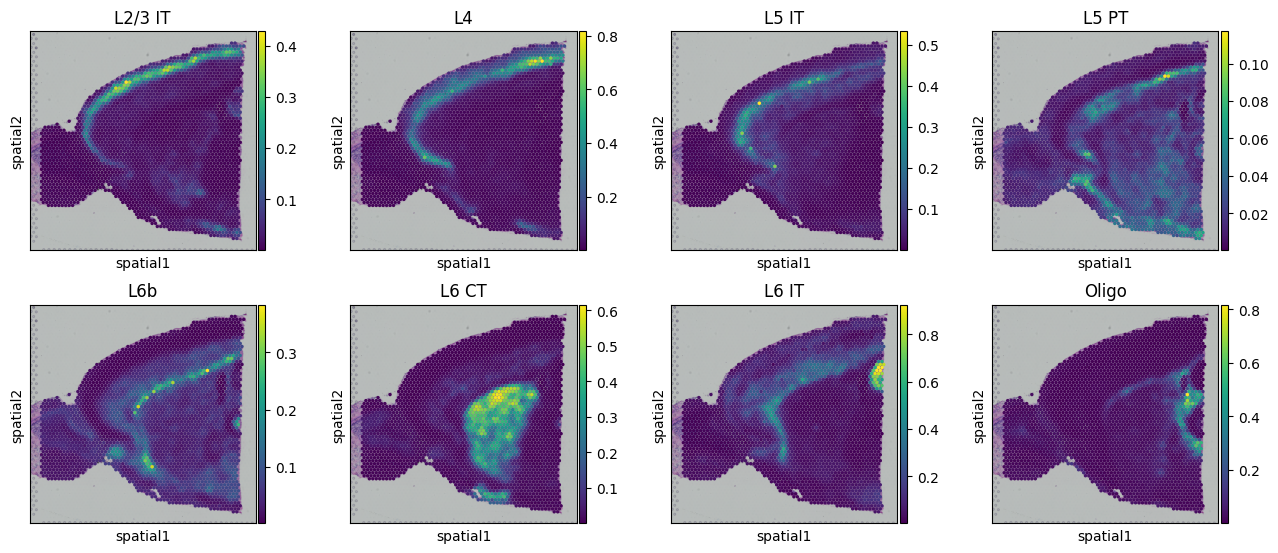

In [4]:
label = ['L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'L6b', 'L6 CT', 'L6 IT','Oligo']
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(AddaGCN.adata_sp,
              img_key="hires",
              color=label,
              palette='Set1',
              size=1.5,
              ncols=4,
              legend_loc=None,
              title=label)

# pie plot

In [5]:
adata_pseudo = AddaGCN.adata_pseudo.copy()
adata_sp = AddaGCN.adata_sp.copy()
label = list(adata_pseudo.obsm['pred_label'].columns)
pred_real = adata_sp.obs[label]

location = pd.DataFrame(AddaGCN.adata_sp.obsm['spatial'])
pred_real.index = location.index
location.columns = ['x', 'y']

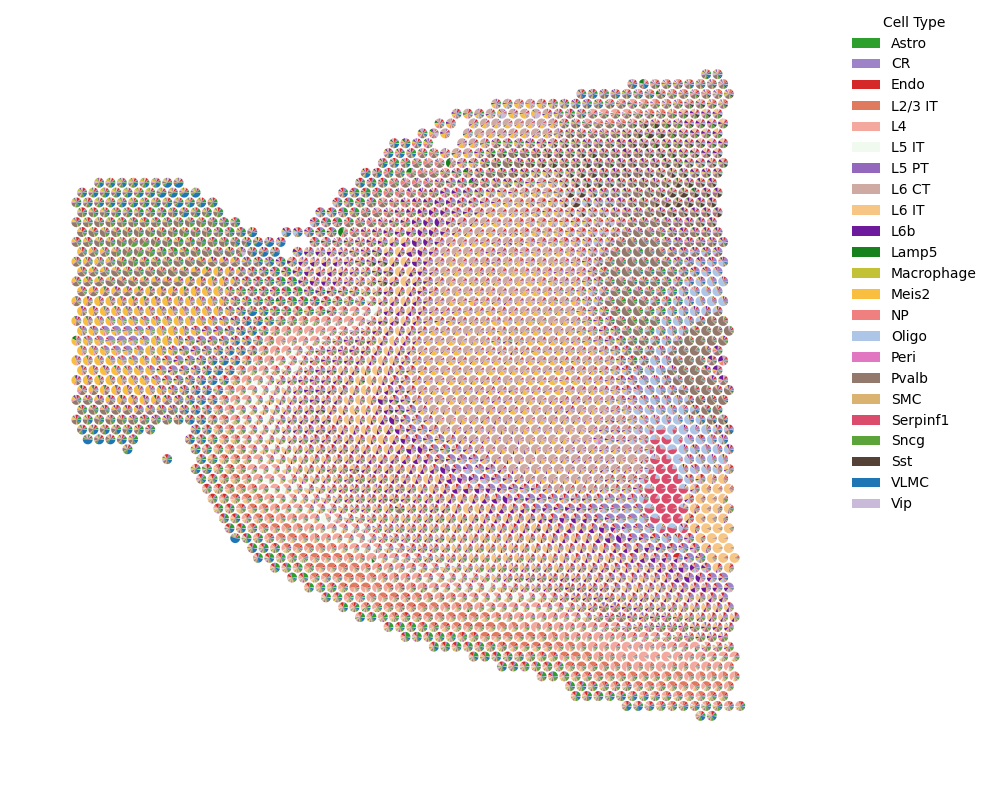

In [6]:
fig, ax = visualize_pie(pred_real, location)
plt.show()